In [2]:
import torch

from scripts.architectures import MLP
from scripts.mnist import get_data
#
import torch.autograd.forward_ad as fwAD



In [15]:

import functorch as ft
import torch.nn as nn
from scripts.losses import multiclass_crossentropy, mse

class miniMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n, 1024),
            nn.ReLU(),
            nn.Linear(1024,10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = miniMLP(2)
input = torch.randn(16, 2)
tangents = tuple([torch.rand_like(p) for p in model.parameters()])

# Given a torch.nn.Module, ft.make_functional_with_buffers extracts the state
# (params and buffers) and returns a functional version of the model that
# can be invoked like a function.
# That is, the returned ``func`` can be invoked like
# ``func(params, buffers, input)``.
# ft.make_functional_with_buffers is analogous to the nn.Modules stateless API
# that you saw previously and we're working on consolidating the two.
func, params, buffers = ft.make_functional_with_buffers(model)

# Because jvp requires every input to be associated with a tangent, we need to
# create a new function that, when given the parameters, produces the output

def func_params_only(params):
    return func(params, buffers, input)

with torch.no_grad():
    model_output, jvp_out = ft.jvp(func_params_only, (params,), (tangents,))


In [16]:
n = 10
ex = 100
x = torch.normal(1, 1, (ex,2))
y = torch.tensor([[1,0] for _ in range(ex)])
x = torch.cat([x,torch.normal(-2,1, (ex,2))])
y = torch.cat([y,torch.tensor([[0,1] for _ in range(ex)])])

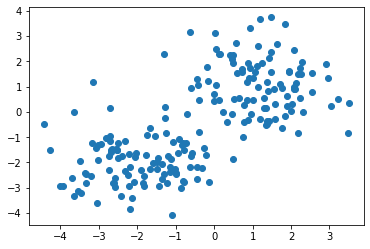

In [17]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1])

In [18]:
trainloader, testloader = get_data('../datasets')
def accuracy(y,y_hat):
    return torch.sum(y == y_hat)/y_hat.shape[0]
def sgd(model, tangents, jvp, rate):
    for p,t  in zip(model.parameters(), tangents):
        new_p = p - rate*jvp*t
        p = new_p

def train_epoch(model,trainloader, optimizer, loss, rate):
    tot_loss = 0
    for x, y in trainloader:
        x = x.reshape((x.shape[0], 28*28))
        y = torch.nn.functional.one_hot(y)
        func, params, buffers = ft.make_functional_with_buffers(model)
        model_functional_on_params = lambda params: loss(y,func(params,buffers, x))

        with torch.no_grad():
            tangents = tuple([torch.normal(0,1,p.shape) for p in model.parameters()])
            num_loss, jvp = ft.jvp(model_functional_on_params, (params,), (tangents,))
            optimizer(model, tangents, jvp, rate)


def train(  model, 
            trainloader, 
            validationloader, 
            optimizer, 
            loss,
            epochs = 10,
            rate = 0.01):
            
    for _ in range(epochs):
        model.train()
        train_epoch(model,trainloader,optimizer,loss, rate)
        model.eval()
        tot_perf = 0
        count = 0
        for x,y in validationloader:
            x = x.reshape((x.shape[0], 28*28))
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim = 1)
            tot_perf += accuracy(y,y_hat)*y_hat.shape[0] 
            count += y_hat.shape[0]
        print("acc test", tot_perf/count)
        

model = miniMLP(784)

In [19]:
train(model,trainloader,testloader,sgd, mse, epochs= 100)

tensor(0.1074)
tensor(0.1230)
tensor(0.0645)
tensor(0.0938)
tensor(0.0898)
tensor(0.0918)
tensor(0.0996)
tensor(0.0977)
tensor(0.0762)
tensor(0.0977)
tensor(0.0938)
tensor(0.1113)
tensor(0.0723)
tensor(0.0977)
tensor(0.1270)
tensor(0.0977)
tensor(0.1016)
tensor(0.0859)
tensor(0.1172)
tensor(0.1152)
tensor(0.0879)
tensor(0.1113)
tensor(0.0918)
tensor(0.0879)
tensor(0.0996)
tensor(0.1074)
tensor(0.0879)
tensor(0.0938)
tensor(0.0898)
tensor(0.1035)
tensor(0.0918)
tensor(0.1055)
tensor(0.1270)
tensor(0.0918)
tensor(0.0898)
tensor(0.0938)
tensor(0.0957)
tensor(0.0957)
tensor(0.0781)
tensor(0.1094)
tensor(0.1074)
tensor(0.1133)
tensor(0.1074)
tensor(0.1348)
tensor(0.1133)
tensor(0.1074)
tensor(0.0879)
tensor(0.0801)
tensor(0.1055)
tensor(0.0996)
tensor(0.1133)
tensor(0.0781)
tensor(0.0996)
tensor(0.1113)
tensor(0.1094)
tensor(0.1094)
tensor(0.1113)
tensor(0.0957)
tensor(0.0938)
tensor(0.0820)
tensor(0.0957)
tensor(0.1094)
tensor(0.0723)
tensor(0.1016)
tensor(0.1211)
tensor(0.1113)
tensor(0.1